In [45]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import bisect

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

# Problem 1

In [2]:
def step_Euler(func,t0,x0,h):
    t1 = t0 + h
    x1 = x0 + h*func(x0,t0)
    return np.array([t1,x1,h])

In [3]:
def step_mod_Euler(func,t0,x0,h):
    t1,xp,h = step_Euler(func,t0,x0,h)
    x1 = x0 + 0.5*h*(func(xp,t1) + func(x0,t0))
    return np.array([t1,x1,h])

In [4]:
def step_RKF45(func,t0,x0,h,tol):
    A = np.array([
        [0,0,0,0,0,0],
        [1/4,0,0,0,0,0],
        [3/32,9/32,0,0,0,0],
        [1932/2197,-7200/2197,7296/2197,0,0,0],
        [439/216,-8,3680/513,-845/4104,0,0],
        [-8/27,2,-3544/2565,1859/4104,-11/40,0]
    ])
    B = np.array([0,1/4,3/8,12/13,1,1/2])
    
    K = np.zeros(6)
    K[0] = h*func(x0+np.sum(A[0]*K),t0+B[0]*h)
    K[1] = h*func(x0+np.sum(A[0]*K),t0+B[1]*h)
    K[2] = h*func(x0+np.sum(A[2]*K),t0+B[2]*h)
    K[3] = h*func(x0+np.sum(A[3]*K),t0+B[3]*h)
    K[4] = h*func(x0+np.sum(A[4]*K),t0+B[4]*h)
    K[5] = h*func(x0+np.sum(A[5]*K),t0+B[5]*h)
    
    t1  = t0 + h
    x1  = x0 + np.sum(np.array([16/135,0,6656/12825,28561/56430,-9/50,2/55])*K)
    err = np.abs(np.sum(np.array([1/360,0,-128/4275,-2197/75240,1/50,2/55])*K) + 1e-100)
    
    if err < tol:
        h1 = min(0.9*h*(tol/err)**(1/6),2*h)
        return np.array([t1,x1,h1])
    else:
        h1 = min(0.9*h*(tol/err)**(1/6),h/2)
        return step_RKF45(func,t0,x0,h1,tol)

In [5]:
def solve_ODE(func,t0,x0,h,tf,tol=1e-4,method='RKF45',max_iter=int(1e3)):
    if method == 'RKF45':
        step_func = lambda t0_,x0_,h_: step_RKF45(func,t0_,x0_,h_,tol)
    elif method == 'modified Euler':
        step_func = lambda t0_,x0_,h_: step_mod_Euler(func,t0_,x0_,h_)
    elif method == 'Euler':
        step_func = lambda t0_,x0_,h_: step_Euler(func,t0_,x0_,h_)
        
    results = [[t0,x0]]
    for i in range(max_iter):
        t1,x1,h = step_func(*results[-1],h)
        results.append([t1,x1])
        
        if t1 > tf:
            break
            
    return np.array(results).T

# Problem 2

In [14]:
setups = [
    [lambda x,t: x + np.exp(-t), 0, 0],
    [lambda x,t: x + 2*np.cos(t), 0, 1],
    [lambda x,t: t*x**2, 0, 1],
    [lambda x,t: 1.5*np.sin(2*x) - x*np.cos(t), 0, 1]
]
h   = 0.1
tf  = 1

In [15]:
results = []
for setup in setups:
    temp = {}
    for method in ['Euler','modified Euler','RKF45']:
        temp[method] = solve_ODE(*setup,h,tf,method=method)
    results.append(temp)

In [16]:
exact = [
    lambda t: np.sinh(t),
    lambda t: 2*np.exp(t) + np.sin(t) - np.cos(t),
    lambda t: 2/(2-t**2)
]

T = np.linspace(0,1)
exact_ = [_(T) for _ in exact]

/var/folders/_b/29vq0z955j77svdys97cr5p40000gn/T/ipykernel_25709/3508046380.py:21: RuntimeWarning: invalid value encountered in true_divide
  r = _[1]/exact[i](_[0])


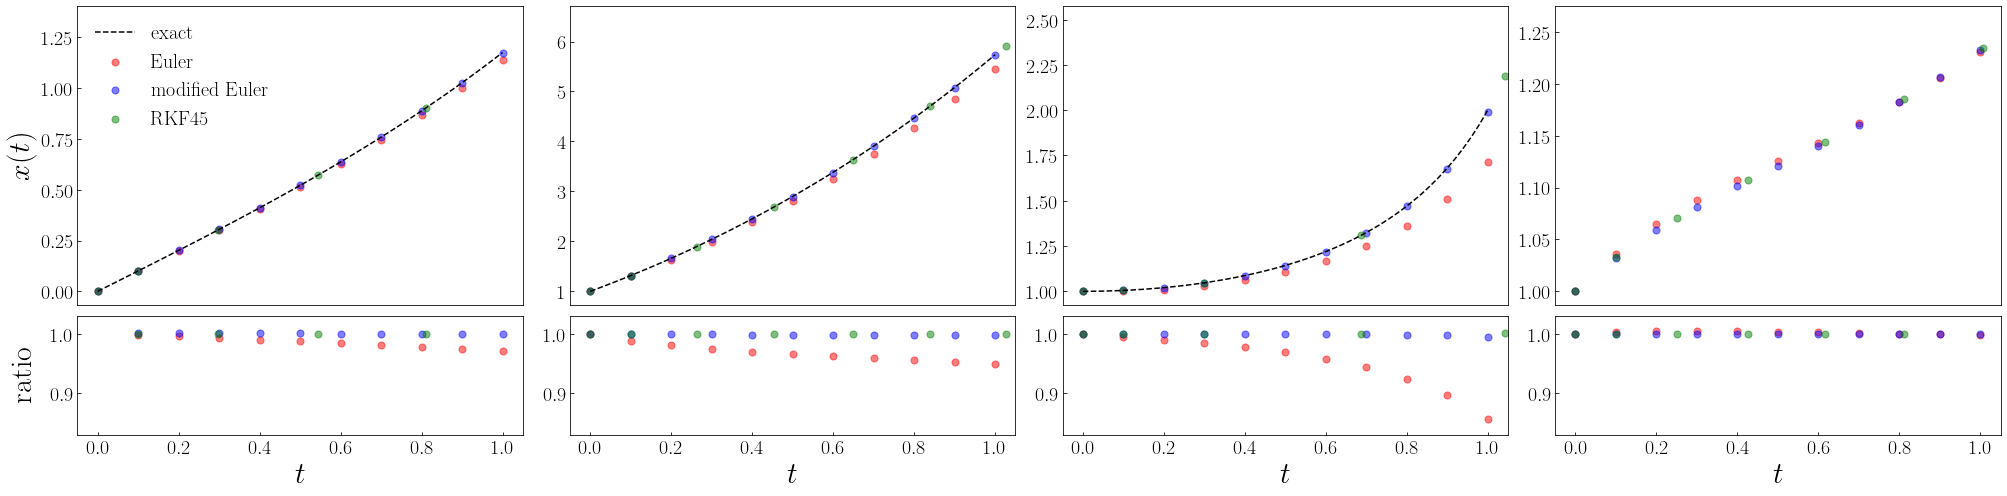

In [17]:
nrows,ncols=2,4
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,7),gridspec_kw={'height_ratios':[5,2]})

color  = ['r','b','g']
labels = [r'$\rm Euler$',r'$\rm modified~Euler$',r'${\rm RKF}45$']
for i in range(4):
    temp = results[i]
    
    if i == 3:
        interp = interp1d(temp['RKF45'][0],temp['RKF45'][1],kind='cubic')
    
    if i != 3:
        ax[0][i].plot(T,exact_[i],'k--',label=r'$\rm exact$')
        
    for j,method in enumerate(temp):
        _ = temp[method]
        
        ax[0][i].scatter(_[0],_[1],marker='o',s=50,color=color[j],edgecolor=color[j],alpha=0.5,label=labels[j] if i==0 else '')
        
        if i != 3:
            r = _[1]/exact[i](_[0])
            ax[1][i].scatter(_[0],r,marker='o',s=50,color=color[j],edgecolor=color[j],alpha=0.5)
        else:
            cond = _[0] < _[0][-1]
            r = _[1][cond]/interp(_[0][cond])
            ax[1][i].scatter(_[0][cond],r,marker='o',s=50,color=color[j],edgecolor=color[j],alpha=0.5)
            
        
    
    for k in range(2):
        ax[k][i].tick_params(axis='both',which='major',direction='in',labelsize=20)
        ax[k][i].set_xlim(-0.05,1.05)
    ax[1][i].set_xlabel(r'$t$',size=30)
    ax[0][i].set_xticks([],[])
    ax[1][i].set_ylim(0.83,1.03)

ax[0][0].set_ylabel(r'$x(t)$',size=30)
ax[1][0].set_ylabel(r'$\rm ratio$',size=30)
ax[0][0].legend(fontsize=20,loc='upper left',frameon=False)

fig.align_labels()
plt.tight_layout()
plt.show()
fig.savefig(r'prob2.pdf',bbox_inches='tight')

# Problem 3

In [18]:
f = lambda x,t: 1.5*np.sin(2*x) - x*np.cos(t)
h = [1e-3,0.1,1]
results = []
for _ in h:
    results.append(solve_ODE(f,0,1,_,1,method='RKF45'))

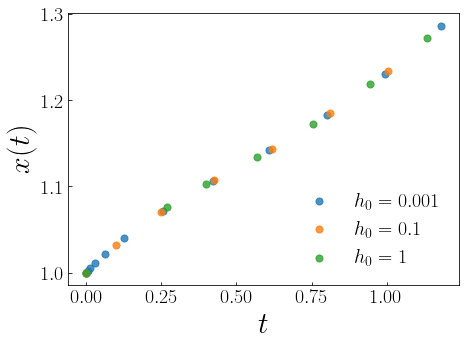

In [24]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

for i,_ in enumerate(h):
    t,x = results[i]
    ax.scatter(t,x,marker='o',s=50,color='C%d'%i,edgecolor='C%d'%i,alpha=0.8,label=r'$h_0=%.1g$'%_)

ax.tick_params(axis='both',which='major',direction='in',labelsize=20)
ax.legend(fontsize=20,loc='lower right',frameon=False)
ax.set_xlabel(r'$t$',size=30)
ax.set_ylabel(r'$x(t)$',size=30)
    
plt.show()

# Problem 4

### part (a)

In [26]:
k  = 0.05
TM = 90

f  = lambda x,t: -k*(x - TM)

T0 = 20
tf = 10
h  = tf/100
results = solve_ODE(f,0,T0,h,tf,method='RKF45')

In [32]:
T = interp1d(*results)
T(10)

array(47.50354853)

### part (b)

In [41]:
m  = 1
g  = 9.80665
b  = 1

a  = lambda v,t: -g - b/m*v
t0 = 0
v0 = 20

In [47]:
results = [[t0,v0]]
h   = 1e-3
tol = 1e-6
while results[-1][1] > 0:
    temp = step_RKF45(a,*results[-1],h,tol)
    results.append(list(temp[:-1]))
    h = temp[-1]
results = np.array(results).T

In [51]:
v  = interp1d(*results)
tp = bisect(v,results[0][0],results[0][-1])
tp

1.1119458084889253

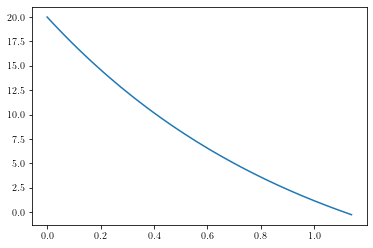

In [54]:
T = np.linspace(*results[0][[0,-1]])
plt.plot(T,v(T))
plt.show()

### part (c)

In [55]:
m  = 1
g  = 9.80665
c  = 0.1

a  = lambda v,t: -g - c/m*v**2
t0 = 0
v0 = 20

In [56]:
results = [[t0,v0]]
h   = 1e-3
tol = 1e-6
while results[-1][1] > 0:
    temp = step_RKF45(a,*results[-1],h,tol)
    results.append(list(temp[:-1]))
    h = temp[-1]
results = np.array(results).T

In [57]:
v  = interp1d(*results)
tp = bisect(v,results[0][0],results[0][-1])
tp

1.1219521370951833

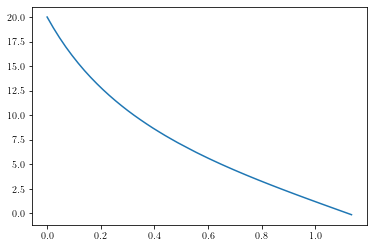

In [58]:
T = np.linspace(*results[0][[0,-1]])
plt.plot(T,v(T))
plt.show()